# Artificial Token Language Research Experiment

**Research Question**: Can a compact, carefully designed artificial token language reduce LLM model size and computational requirements while maintaining or improving reasoning quality compared to standard tokenization methods?

**Date**: December 7, 2025

## Experimental Phases

1. Download and prepare datasets (TinyStories, WikiText-103)
2. Analyze natural language patterns
3. Design artificial token language
4. Implement tokenizers (Artificial, BPE, Unigram, Byte)
5. Evaluate compression efficiency
6. Statistical analysis and comparison

## Setup

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import Counter, defaultdict
import json
import random
from tqdm import tqdm
import re
from pathlib import Path

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(42)

print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)

# Create results directory
os.makedirs('../results', exist_ok=True)
os.makedirs('../results/plots', exist_ok=True)
os.makedirs('../results/tokenizers', exist_ok=True)

print("\n✓ Environment setup complete")

/data/haokunliu/idea-explorer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.12.2 | packaged by Anaconda, Inc. | (main, Feb 27 2024, 17:35:02) [GCC 11.2.0]
NumPy version: 2.3.4
Pandas version: 2.3.3

✓ Environment setup complete


## Phase 1: Download and Prepare Datasets

We'll download:
1. **TinyStories**: Small dataset for initial experiments (used in Vocab Compression paper)
2. **WikiText-103**: Standard benchmark for evaluation

In [2]:
# Download TinyStories dataset (small subset for fast experimentation)
print("Downloading TinyStories dataset...")
tinystories = load_dataset("roneneldan/TinyStories", split="train[:10000]")  # 10K samples for speed
print(f"✓ Loaded {len(tinystories)} stories from TinyStories")

# Download WikiText-103 dataset
print("\nDownloading WikiText-103 dataset...")
wikitext = load_dataset("Salesforce/wikitext", "wikitext-103-v1")
wikitext_test = wikitext["test"]
print(f"✓ Loaded WikiText-103: {len(wikitext_test)} test samples")

# Sample data
print("\n" + "="*80)
print("SAMPLE FROM TINYSTORIES:")
print("="*80)
print(tinystories[0]["text"][:500])
print("\n" + "="*80)
print("SAMPLE FROM WIKITEXT-103:")
print("="*80)
print(wikitext_test[0]["text"][:500])

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating train split:   1%|          | 20000/2119719 [00:00<00:10, 193076.36 examples/s]

Generating train split:   2%|▏         | 49000/2119719 [00:00<00:08, 243376.19 examples/s]

Generating train split:   3%|▎         | 74000/2119719 [00:00<00:08, 241295.26 examples/s]

Generating train split:   5%|▍         | 99000/2119719 [00:00<00:08, 241971.32 examples/s]

Generating train split:   6%|▋         | 135000/2119719 [00:00<00:08, 239720.59 examples/s]

Generating train split:   8%|▊         | 168000/2119719 [00:00<00:08, 224868.30 examples/s]

Generating train split:   9%|▉         | 196000/2119719 [00:00<00:08, 235597.67 examples/s]

Generating train split:  11%|█         | 231000/2119719 [00:00<00:08, 230855.49 examples/s]

Generating train split:  12%|█▏        | 257000/2119719 [00:01<00:07, 234606.64 examples/s]

Generating train split:  13%|█▎        | 283000/2119719 [00:01<00:07, 238469.78 examples/s]

Generating train split:  15%|█▌        | 322000/2119719 [00:01<00:07, 244549.69 examples/s]

Generating train split:  16%|█▋        | 347000/2119719 [00:01<00:07, 244258.42 examples/s]

Generating train split:  18%|█▊        | 383000/2119719 [00:01<00:07, 235708.73 examples/s]

Generating train split:  19%|█▉        | 410000/2119719 [00:01<00:07, 241620.61 examples/s]

Generating train split:  21%|██        | 443000/2119719 [00:01<00:07, 230748.30 examples/s]

Generating train split:  23%|██▎       | 479000/2119719 [00:02<00:07, 231430.30 examples/s]

Generating train split:  24%|██▍       | 516000/2119719 [00:02<00:06, 233969.51 examples/s]

Generating train split:  26%|██▌       | 544930/2119719 [00:02<00:07, 217216.67 examples/s]

Generating train split:  27%|██▋       | 568930/2119719 [00:02<00:07, 219824.35 examples/s]

Generating train split:  28%|██▊       | 595930/2119719 [00:02<00:06, 228707.42 examples/s]

Generating train split:  30%|██▉       | 627930/2119719 [00:02<00:06, 220491.84 examples/s]

Generating train split:  31%|███       | 652930/2119719 [00:02<00:06, 222887.09 examples/s]

Generating train split:  32%|███▏      | 686930/2119719 [00:02<00:06, 220548.87 examples/s]

Generating train split:  34%|███▎      | 711930/2119719 [00:03<00:06, 224602.78 examples/s]

Generating train split:  35%|███▍      | 736930/2119719 [00:03<00:06, 227395.32 examples/s]

Generating train split:  36%|███▋      | 770930/2119719 [00:03<00:06, 221954.43 examples/s]

Generating train split:  38%|███▊      | 794930/2119719 [00:03<00:05, 224214.93 examples/s]

Generating train split:  39%|███▉      | 825930/2119719 [00:03<00:06, 213297.09 examples/s]

Generating train split:  40%|████      | 851930/2119719 [00:03<00:05, 222663.29 examples/s]

Generating train split:  41%|████▏     | 876930/2119719 [00:03<00:05, 228269.48 examples/s]

Generating train split:  43%|████▎     | 909930/2119719 [00:03<00:05, 218833.65 examples/s]

Generating train split:  44%|████▍     | 933930/2119719 [00:04<00:05, 222585.65 examples/s]

Generating train split:  45%|████▌     | 958930/2119719 [00:04<00:05, 215174.01 examples/s]

Generating train split:  46%|████▋     | 982930/2119719 [00:04<00:05, 220900.04 examples/s]

Generating train split:  48%|████▊     | 1007930/2119719 [00:04<00:04, 228286.33 examples/s]

Generating train split:  49%|████▉     | 1045930/2119719 [00:04<00:04, 233613.11 examples/s]

Generating train split:  51%|█████     | 1074860/2119719 [00:04<00:04, 216672.38 examples/s]

Generating train split:  52%|█████▏    | 1103860/2119719 [00:04<00:04, 230763.36 examples/s]

Generating train split:  53%|█████▎    | 1128860/2119719 [00:04<00:04, 231581.69 examples/s]

Generating train split:  55%|█████▌    | 1165860/2119719 [00:05<00:04, 233505.09 examples/s]

Generating train split:  56%|█████▌    | 1191860/2119719 [00:05<00:03, 237889.88 examples/s]

Generating train split:  58%|█████▊    | 1224860/2119719 [00:05<00:03, 228889.55 examples/s]

Generating train split:  59%|█████▉    | 1249860/2119719 [00:05<00:03, 230907.48 examples/s]

Generating train split:  60%|██████    | 1273860/2119719 [00:05<00:03, 230612.25 examples/s]

Generating train split:  62%|██████▏   | 1306860/2119719 [00:05<00:03, 225296.68 examples/s]

Generating train split:  63%|██████▎   | 1332860/2119719 [00:05<00:03, 230900.93 examples/s]

Generating train split:  64%|██████▍   | 1358860/2119719 [00:05<00:03, 228443.56 examples/s]

Generating train split:  65%|██████▌   | 1381860/2119719 [00:06<00:03, 225341.06 examples/s]

Generating train split:  66%|██████▋   | 1404860/2119719 [00:06<00:03, 224013.23 examples/s]

Generating train split:  68%|██████▊   | 1436860/2119719 [00:06<00:03, 215105.44 examples/s]

Generating train split:  69%|██████▉   | 1462860/2119719 [00:06<00:02, 222089.92 examples/s]

Generating train split:  70%|███████   | 1486860/2119719 [00:06<00:02, 224647.02 examples/s]

Generating train split:  72%|███████▏  | 1517860/2119719 [00:06<00:02, 214533.77 examples/s]

Generating train split:  73%|███████▎  | 1540860/2119719 [00:06<00:02, 217642.77 examples/s]

Generating train split:  74%|███████▍  | 1563860/2119719 [00:06<00:02, 219198.78 examples/s]

Generating train split:  75%|███████▌  | 1591790/2119719 [00:07<00:02, 203396.14 examples/s]

Generating train split:  76%|███████▋  | 1618790/2119719 [00:07<00:02, 216979.56 examples/s]

Generating train split:  78%|███████▊  | 1645790/2119719 [00:07<00:02, 228801.02 examples/s]

Generating train split:  79%|███████▉  | 1680790/2119719 [00:07<00:01, 227439.54 examples/s]

Generating train split:  81%|████████  | 1707790/2119719 [00:07<00:01, 235110.27 examples/s]

Generating train split:  82%|████████▏ | 1732790/2119719 [00:07<00:01, 237506.10 examples/s]

Generating train split:  83%|████████▎ | 1757790/2119719 [00:07<00:01, 237684.37 examples/s]

Generating train split:  84%|████████▍ | 1790790/2119719 [00:07<00:01, 228146.90 examples/s]

Generating train split:  86%|████████▌ | 1822790/2119719 [00:08<00:01, 220164.80 examples/s]

Generating train split:  87%|████████▋ | 1846790/2119719 [00:08<00:01, 221062.22 examples/s]

Generating train split:  88%|████████▊ | 1869790/2119719 [00:08<00:01, 219804.42 examples/s]

Generating train split:  90%|████████▉ | 1902790/2119719 [00:08<00:01, 214838.15 examples/s]

Generating train split:  91%|█████████ | 1926790/2119719 [00:08<00:00, 218478.29 examples/s]

Generating train split:  93%|█████████▎| 1960790/2119719 [00:08<00:00, 212068.18 examples/s]

Generating train split:  94%|█████████▍| 1992790/2119719 [00:08<00:00, 210439.40 examples/s]

Generating train split:  95%|█████████▌| 2022790/2119719 [00:08<00:00, 204500.79 examples/s]

Generating train split:  97%|█████████▋| 2045790/2119719 [00:09<00:00, 207611.80 examples/s]

Generating train split:  98%|█████████▊| 2066790/2119719 [00:09<00:00, 207014.73 examples/s]

Generating train split:  98%|█████████▊| 2087790/2119719 [00:09<00:00, 205201.34 examples/s]

Generating train split: 100%|█████████▉| 2116790/2119719 [00:09<00:00, 196765.69 examples/s]

Generating train split: 100%|██████████| 2119719/2119719 [00:09<00:00, 223614.49 examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Generating validation split:  95%|█████████▌| 21000/21990 [00:00<00:00, 200559.65 examples/s]

Generating validation split: 100%|██████████| 21990/21990 [00:00<00:00, 205072.85 examples/s]

✓ Loaded 10000 stories from TinyStories



Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating test split: 100%|██████████| 4358/4358 [00:00<00:00, 411396.93 examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating train split:   3%|▎         | 50000/1801350 [00:00<00:03, 492423.29 examples/s]

Generating train split:   6%|▋         | 115000/1801350 [00:00<00:02, 581879.69 examples/s]

Generating train split:  10%|▉         | 176000/1801350 [00:00<00:02, 591493.10 examples/s]

Generating train split:  14%|█▍        | 259000/1801350 [00:00<00:02, 569884.55 examples/s]

Generating train split:  18%|█▊        | 323000/1801350 [00:00<00:02, 588063.63 examples/s]

Generating train split:  21%|██▏       | 384000/1801350 [00:00<00:02, 593671.00 examples/s]

Generating train split:  26%|██▌       | 467000/1801350 [00:00<00:02, 576014.13 examples/s]

Generating train split:  30%|██▉       | 533000/1801350 [00:00<00:02, 595461.21 examples/s]

Generating train split:  34%|███▍      | 620000/1801350 [00:01<00:02, 584871.90 examples/s]

Generating train split:  39%|███▊      | 695000/1801350 [00:01<00:01, 625948.94 examples/s]

Generating train split:  43%|████▎     | 767000/1801350 [00:01<00:01, 647517.25 examples/s]

Generating train split:  46%|████▋     | 837000/1801350 [00:01<00:01, 660774.97 examples/s]

Generating train split:  52%|█████▏    | 938675/1801350 [00:01<00:01, 653042.31 examples/s]

Generating train split:  56%|█████▋    | 1017675/1801350 [00:01<00:01, 686296.87 examples/s]

Generating train split:  61%|██████    | 1091675/1801350 [00:01<00:01, 694953.67 examples/s]

Generating train split:  66%|██████▌   | 1189675/1801350 [00:01<00:00, 675431.52 examples/s]

Generating train split:  72%|███████▏  | 1288675/1801350 [00:02<00:00, 653293.71 examples/s]

Generating train split:  75%|███████▌  | 1357675/1801350 [00:02<00:00, 660236.55 examples/s]

Generating train split:  79%|███████▉  | 1424675/1801350 [00:02<00:00, 658792.61 examples/s]

Generating train split:  84%|████████▍ | 1516675/1801350 [00:02<00:00, 640097.88 examples/s]

Generating train split:  88%|████████▊ | 1586675/1801350 [00:02<00:00, 653230.85 examples/s]

Generating train split:  92%|█████████▏| 1661675/1801350 [00:02<00:00, 676340.86 examples/s]

Generating train split:  96%|█████████▋| 1735675/1801350 [00:02<00:00, 691157.66 examples/s]

Generating train split: 100%|██████████| 1801350/1801350 [00:02<00:00, 645607.76 examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Generating validation split: 100%|██████████| 3760/3760 [00:00<00:00, 509632.67 examples/s]

✓ Loaded WikiText-103: 4358 test samples

SAMPLE FROM TINYSTORIES:
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them b

SAMPLE FROM WIKITEXT-103:



## Phase 2: Analyze Natural Language Patterns

We'll analyze TinyStories to extract:
1. Word frequency distribution
2. Common morphemes (prefixes, suffixes)
3. Frequent multi-word phrases
4. Character n-gram statistics

In [3]:
# Collect all text from TinyStories
all_text = " ".join([story["text"] for story in tinystories])
print(f"Total characters in TinyStories subset: {len(all_text):,}")

# Tokenize into words (simple whitespace + punctuation split)
import re
words = re.findall(r'\b\w+\b|[^\w\s]', all_text.lower())
print(f"Total words: {len(words):,}")

# Word frequency analysis
word_freq = Counter(words)
print(f"Unique words: {len(word_freq):,}")

# Top 50 most frequent words
print("\n" + "="*80)
print("TOP 50 MOST FREQUENT WORDS:")
print("="*80)
top_words = word_freq.most_common(50)
for i, (word, count) in enumerate(top_words, 1):
    print(f"{i:2d}. {word:15s} : {count:6d} ({count/len(words)*100:5.2f}%)")

# Calculate cumulative coverage
cumulative_coverage = []
sorted_words = word_freq.most_common()
cumulative = 0
for i, (word, count) in enumerate(sorted_words):
    cumulative += count
    if i + 1 in [10, 50, 100, 500, 1000, 2000, 5000]:
        cumulative_coverage.append((i+1, cumulative/len(words)*100))
        
print("\n" + "="*80)
print("VOCABULARY COVERAGE:")
print("="*80)
for vocab_size, coverage in cumulative_coverage:
    print(f"Top {vocab_size:5d} words cover {coverage:5.2f}% of all tokens")

Total characters in TinyStories subset: 8,684,760


Total words: 2,053,886
Unique words: 9,565

TOP 50 MOST FREQUENT WORDS:
 1. .               : 159928 ( 7.79%)
 2. the             :  93147 ( 4.54%)
 3. ,               :  81954 ( 3.99%)
 4. and             :  80349 ( 3.91%)
 5. to              :  57209 ( 2.79%)
 6. a               :  53141 ( 2.59%)
 7. "               :  45819 ( 2.23%)
 8. was             :  44482 ( 2.17%)
 9. he              :  36269 ( 1.77%)
10. she             :  35382 ( 1.72%)
11. it              :  31655 ( 1.54%)
12. they            :  27397 ( 1.33%)
13. her             :  23206 ( 1.13%)
14. '               :  20474 ( 1.00%)
15. said            :  17340 ( 0.84%)
16. !               :  16235 ( 0.79%)
17. his             :  15003 ( 0.73%)
18. in              :  14967 ( 0.73%)
19. with            :  14207 ( 0.69%)
20. you             :  14149 ( 0.69%)
21. that            :  13547 ( 0.66%)
22. so              :  13315 ( 0.65%)
23. lily            :  12969 ( 0.63%)
24. day             :  12688 ( 0.62%)
25. of          

In [4]:
# Analyze common suffixes and prefixes
from collections import defaultdict

# Common English suffixes
common_suffixes = ['ed', 'ing', 'er', 'ly', 's', 'tion', 'ness', 'ful', 'less', 'ment']
suffix_counts = defaultdict(int)

# Common English prefixes
common_prefixes = ['un', 're', 'pre', 'dis', 'in', 'mis', 'over', 'under']
prefix_counts = defaultdict(int)

for word in word_freq.keys():
    if len(word) > 3:
        # Check suffixes
        for suffix in common_suffixes:
            if word.endswith(suffix):
                suffix_counts[suffix] += word_freq[word]
        
        # Check prefixes
        for prefix in common_prefixes:
            if word.startswith(prefix):
                prefix_counts[prefix] += word_freq[word]

print("="*80)
print("COMMON SUFFIXES (by frequency):")
print("="*80)
for suffix, count in sorted(suffix_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{suffix:10s} : {count:8d} occurrences")

print("\n" + "="*80)
print("COMMON PREFIXES (by frequency):")
print("="*80)
for prefix, count in sorted(prefix_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{prefix:10s} : {count:8d} occurrences")

COMMON SUFFIXES (by frequency):
ed         :    97590 occurrences
s          :    64690 occurrences
ing        :    33911 occurrences
er         :    31147 occurrences
ly         :    27869 occurrences
ful        :     4814 occurrences
tion       :      801 occurrences
ment       :      765 occurrences
less       :      369 occurrences
ness       :      313 occurrences

COMMON PREFIXES (by frequency):
re         :     8439 occurrences
in         :     5026 occurrences
un         :     3333 occurrences
pre        :     1874 occurrences
over       :     1627 occurrences
dis        :     1164 occurrences
under      :     1052 occurrences
mis        :      650 occurrences


## Phase 3: Design Artificial Token Language

Based on our analysis:
- Top 50 words cover 56% of tokens
- Top 1000 words cover 92% of tokens
- Common suffixes: -ed, -s, -ing, -er, -ly
- Common prefixes: re-, in-, un-

**Design Strategy:**
1. **Core vocabulary**: Top 800 most frequent complete words
2. **Morpheme tokens**: Common prefixes and suffixes (20 tokens)
3. **Character fallback**: For rare/unknown words
4. **Target vocabulary size**: ~1000-1500 tokens (vs BPE 50K, Byte 256)

In [5]:
# Design Artificial Token Language
print("DESIGNING ARTIFICIAL TOKEN LANGUAGE...")
print("="*80)

# Core vocabulary: top 800 words (covers ~90% of tokens)
core_vocab_size = 800
core_vocab = [word for word, count in word_freq.most_common(core_vocab_size)]

# Morpheme tokens (prefixes and suffixes)
morpheme_tokens = {
    'prefixes': ['re-', 'un-', 'in-', 'pre-', 'dis-', 'over-', 'under-', 'mis-'],
    'suffixes': ['-ed', '-ing', '-er', '-ly', '-s', '-tion', '-ment', '-ful', '-less', '-ness']
}

# Special tokens
special_tokens = ['<PAD>', '<UNK>', '<BOS>', '<EOS>', '<SPACE>']

# Build complete vocabulary
artificial_vocab = special_tokens.copy()
artificial_vocab.extend(core_vocab)
artificial_vocab.extend(morpheme_tokens['prefixes'])
artificial_vocab.extend(morpheme_tokens['suffixes'])

# Add lowercase alphabet for fallback
alphabet = list('abcdefghijklmnopqrstuvwxyz')
artificial_vocab.extend(alphabet)

# Add common punctuation and digits
punctuation = list('.,!?;:\'"()-[]{}')
digits = list('0123456789')
artificial_vocab.extend(punctuation)
artificial_vocab.extend(digits)

print(f"Total vocabulary size: {len(artificial_vocab)}")
print(f"  - Special tokens: {len(special_tokens)}")
print(f"  - Core words: {core_vocab_size}")
print(f"  - Morphemes: {len(morpheme_tokens['prefixes']) + len(morpheme_tokens['suffixes'])}")
print(f"  - Alphabet: {len(alphabet)}")
print(f"  - Punctuation: {len(punctuation)}")
print(f"  - Digits: {len(digits)}")

# Create token-to-id mapping
token_to_id = {token: i for i, token in enumerate(artificial_vocab)}
id_to_token = {i: token for token, i in token_to_id.items()}

# Save vocabulary
vocab_info = {
    'vocabulary': artificial_vocab,
    'token_to_id': token_to_id,
    'core_vocab_size': core_vocab_size,
    'total_size': len(artificial_vocab),
    'design': {
        'core_words': core_vocab_size,
        'prefixes': len(morpheme_tokens['prefixes']),
        'suffixes': len(morpheme_tokens['suffixes']),
        'alphabet': len(alphabet),
        'special': len(special_tokens)
    }
}

with open('../results/artificial_vocab.json', 'w') as f:
    json.dump(vocab_info, f, indent=2)

print(f"\n✓ Saved artificial vocabulary to results/artificial_vocab.json")
print(f"\nVocabulary size comparison:")
print(f"  - Artificial Language: {len(artificial_vocab):,} tokens")
print(f"  - Standard BPE: ~50,000 tokens")
print(f"  - Byte-level: 256 tokens")
print(f"\nCompression vs BPE: {50000/len(artificial_vocab):.1f}x smaller vocabulary")

DESIGNING ARTIFICIAL TOKEN LANGUAGE...
Total vocabulary size: 874
  - Special tokens: 5
  - Core words: 800
  - Morphemes: 18
  - Alphabet: 26
  - Punctuation: 15
  - Digits: 10

✓ Saved artificial vocabulary to results/artificial_vocab.json

Vocabulary size comparison:
  - Artificial Language: 874 tokens
  - Standard BPE: ~50,000 tokens
  - Byte-level: 256 tokens

Compression vs BPE: 57.2x smaller vocabulary


In [6]:
# Implement Artificial Language Tokenizer
class ArtificialLanguageTokenizer:
    def __init__(self, vocab_info):
        self.vocab = vocab_info['vocabulary']
        self.token_to_id = vocab_info['token_to_id']
        self.id_to_token = {i: token for token, i in self.token_to_id.items()}
        self.unk_token = '<UNK>'
        self.unk_id = self.token_to_id[self.unk_token]
        self.space_token = '<SPACE>'
        self.space_id = self.token_to_id[self.space_token]
        
    def encode(self, text):
        """Encode text to token IDs"""
        tokens = []
        
        # Split into words and punctuation
        words_and_punct = re.findall(r'\b\w+\b|[^\w\s]|\s+', text.lower())
        
        for item in words_and_punct:
            if item.isspace():
                # Space becomes a single token
                tokens.append(self.space_id)
            elif item in self.token_to_id:
                # Known word or punctuation
                tokens.append(self.token_to_id[item])
            else:
                # Unknown word - try morpheme decomposition or character fallback
                word_tokens = self._encode_unknown_word(item)
                tokens.extend(word_tokens)
        
        return tokens
    
    def _encode_unknown_word(self, word):
        """Encode unknown word using morphemes or character fallback"""
        tokens = []
        
        # Try to decompose into morphemes
        # Check for prefix
        prefix = None
        for pref in [p.rstrip('-') for p in morpheme_tokens['prefixes']]:
            if word.startswith(pref) and len(word) > len(pref):
                prefix = pref + '-'
                break
        
        # Check for suffix
        suffix = None
        remaining = word[len(prefix.rstrip('-')):] if prefix else word
        for suff in [s.lstrip('-') for s in morpheme_tokens['suffixes']]:
            if remaining.endswith(suff) and len(remaining) > len(suff):
                suffix = '-' + suff
                break
        
        # Build token sequence
        if prefix and prefix in self.token_to_id:
            tokens.append(self.token_to_id[prefix])
            word = word[len(prefix.rstrip('-')):]
        
        # Core part
        core = word[:-len(suffix.lstrip('-'))] if suffix else word
        if core in self.token_to_id:
            tokens.append(self.token_to_id[core])
        else:
            # Character-level fallback
            for char in core:
                if char in self.token_to_id:
                    tokens.append(self.token_to_id[char])
                else:
                    tokens.append(self.unk_id)
        
        if suffix and suffix in self.token_to_id:
            tokens.append(self.token_to_id[suffix])
        
        return tokens if tokens else [self.unk_id]
    
    def decode(self, token_ids):
        """Decode token IDs back to text"""
        text_parts = []
        
        for token_id in token_ids:
            token = self.id_to_token.get(token_id, self.unk_token)
            if token == self.space_token:
                text_parts.append(' ')
            elif token.endswith('-'):
                # Prefix - no space after
                text_parts.append(token.rstrip('-'))
            elif token.startswith('-'):
                # Suffix - no space before
                text_parts.append(token.lstrip('-'))
            else:
                text_parts.append(token)
        
        return ''.join(text_parts)
    
    def tokenize_text(self, text):
        """Tokenize text and return list of tokens (for analysis)"""
        token_ids = self.encode(text)
        return [self.id_to_token[tid] for tid in token_ids]

# Create tokenizer
art_tokenizer = ArtificialLanguageTokenizer(vocab_info)

# Test the tokenizer
test_sentences = [
    "Once upon a time, there was a little girl named Lily.",
    "She wanted to play with her toys.",
    "The dog was very happy and jumped around.",
    "Unprecedented circumstances require rethinking strategies.",  # Has unknown words
]

print("="*80)
print("TESTING ARTIFICIAL LANGUAGE TOKENIZER:")
print("="*80)
for sent in test_sentences:
    tokens = art_tokenizer.tokenize_text(sent)
    token_ids = art_tokenizer.encode(sent)
    decoded = art_tokenizer.decode(token_ids)
    
    print(f"\nOriginal: {sent}")
    print(f"Tokens ({len(tokens)}): {tokens[:20]}{'...' if len(tokens) > 20 else ''}")
    print(f"Decoded: {decoded}")
    print(f"Match: {sent.lower() == decoded.replace('<SPACE>', ' ')}")

TESTING ARTIFICIAL LANGUAGE TOKENIZER:

Original: Once upon a time, there was a little girl named Lily.
Tokens (23): ['once', '<SPACE>', 'upon', '<SPACE>', 'a', '<SPACE>', 'time', ',', '<SPACE>', 'there', '<SPACE>', 'was', '<SPACE>', 'a', '<SPACE>', 'little', '<SPACE>', 'girl', '<SPACE>', 'named']...
Decoded: once upon a time, there was a little girl named lily.
Match: True

Original: She wanted to play with her toys.
Tokens (14): ['she', '<SPACE>', 'wanted', '<SPACE>', 'to', '<SPACE>', 'play', '<SPACE>', 'with', '<SPACE>', 'her', '<SPACE>', 'toys', '.']
Decoded: she wanted to play with her toys.
Match: True

Original: The dog was very happy and jumped around.
Tokens (16): ['the', '<SPACE>', 'dog', '<SPACE>', 'was', '<SPACE>', 'very', '<SPACE>', 'happy', '<SPACE>', 'and', '<SPACE>', 'jumped', '<SPACE>', 'around', '.']
Decoded: the dog was very happy and jumped around.
Match: True

Original: Unprecedented circumstances require rethinking strategies.
Tokens (48): ['un-', 'p', 'r', 'e', '

## Phase 4: Implement Baseline Tokenizers

We'll train and compare:
1. **BPE** (byte-pair encoding) - standard approach
2. **Unigram LM** - shown to outperform BPE
3. **Byte-level** - simple character encoding

In [7]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, processors

# Prepare training corpus
training_corpus = [story["text"] for story in tinystories]

print("Training baseline tokenizers on TinyStories corpus...")
print(f"Training corpus size: {len(training_corpus)} stories")
print("="*80)

# 1. Train BPE tokenizer with matched vocabulary size (~1000)
print("\n1. Training BPE tokenizer (vocab size: 1000)...")
bpe_tokenizer_1k = Tokenizer(models.BPE())
bpe_tokenizer_1k.pre_tokenizer = pre_tokenizers.Whitespace()
bpe_trainer_1k = trainers.BpeTrainer(vocab_size=1000, special_tokens=["<PAD>", "<UNK>", "<BOS>", "<EOS>"])
bpe_tokenizer_1k.train_from_iterator(training_corpus, trainer=bpe_trainer_1k)
print(f"✓ BPE-1K trained: vocab size = {bpe_tokenizer_1k.get_vocab_size()}")

# 2. Train standard BPE tokenizer (vocab size: 5000, closer to practice)
print("\n2. Training BPE tokenizer (vocab size: 5000)...")
bpe_tokenizer_5k = Tokenizer(models.BPE())
bpe_tokenizer_5k.pre_tokenizer = pre_tokenizers.Whitespace()
bpe_trainer_5k = trainers.BpeTrainer(vocab_size=5000, special_tokens=["<PAD>", "<UNK>", "<BOS>", "<EOS>"])
bpe_tokenizer_5k.train_from_iterator(training_corpus, trainer=bpe_trainer_5k)
print(f"✓ BPE-5K trained: vocab size = {bpe_tokenizer_5k.get_vocab_size()}")

# 3. Train Unigram tokenizer with matched vocabulary size
print("\n3. Training Unigram LM tokenizer (vocab size: 1000)...")
unigram_tokenizer = Tokenizer(models.Unigram())
unigram_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
unigram_trainer = trainers.UnigramTrainer(vocab_size=1000, special_tokens=["<PAD>", "<UNK>", "<BOS>", "<EOS>"])
unigram_tokenizer.train_from_iterator(training_corpus, trainer=unigram_trainer)
print(f"✓ Unigram trained: vocab size = {unigram_tokenizer.get_vocab_size()}")

# 4. Simple byte-level tokenizer
print("\n4. Creating byte-level tokenizer...")
class ByteTokenizer:
    def __init__(self):
        self.vocab_size = 256
    
    def encode(self, text):
        return list(text.encode('utf-8'))
    
    def decode(self, byte_ids):
        return bytes(byte_ids).decode('utf-8', errors='ignore')
    
    def get_vocab_size(self):
        return self.vocab_size

byte_tokenizer = ByteTokenizer()
print(f"✓ Byte tokenizer created: vocab size = {byte_tokenizer.get_vocab_size()}")

# Save tokenizers
bpe_tokenizer_1k.save("../results/tokenizers/bpe_1k.json")
bpe_tokenizer_5k.save("../results/tokenizers/bpe_5k.json")
unigram_tokenizer.save("../results/tokenizers/unigram_1k.json")

print("\n" + "="*80)
print("SUMMARY: All tokenizers trained and saved")
print("="*80)
print(f"Artificial Language: {len(artificial_vocab)} tokens")
print(f"BPE-1K: {bpe_tokenizer_1k.get_vocab_size()} tokens")
print(f"BPE-5K: {bpe_tokenizer_5k.get_vocab_size()} tokens")
print(f"Unigram-1K: {unigram_tokenizer.get_vocab_size()} tokens")
print(f"Byte-level: {byte_tokenizer.get_vocab_size()} tokens")

Training baseline tokenizers on TinyStories corpus...
Training corpus size: 10000 stories

1. Training BPE tokenizer (vocab size: 1000)...





✓ BPE-1K trained: vocab size = 1000

2. Training BPE tokenizer (vocab size: 5000)...





✓ BPE-5K trained: vocab size = 5000

3. Training Unigram LM tokenizer (vocab size: 1000)...




✓ Unigram trained: vocab size = 1000

4. Creating byte-level tokenizer...
✓ Byte tokenizer created: vocab size = 256

SUMMARY: All tokenizers trained and saved
Artificial Language: 874 tokens
BPE-1K: 1000 tokens
BPE-5K: 5000 tokens
Unigram-1K: 1000 tokens
Byte-level: 256 tokens


## Phase 5: Compression Evaluation

We'll measure compression efficiency on multiple datasets:
1. **TinyStories** (training data)
2. **WikiText-103** (out-of-domain)

**Metrics:**
- Tokens per byte (compression ratio)
- Tokens per word
- Vocabulary utilization

In [9]:
# Compression Evaluation Function
def evaluate_compression(tokenizer, text_samples, tokenizer_name):
    """Evaluate compression efficiency of a tokenizer"""
    total_bytes = 0
    total_tokens = 0
    total_words = 0
    
    for text in tqdm(text_samples, desc=f"Evaluating {tokenizer_name}"):
        # Count bytes
        total_bytes += len(text.encode('utf-8'))
        
        # Count words (simple whitespace split)
        total_words += len(text.split())
        
        # Count tokens
        if isinstance(tokenizer, ArtificialLanguageTokenizer):
            tokens = tokenizer.encode(text)
        elif isinstance(tokenizer, ByteTokenizer):
            tokens = tokenizer.encode(text)
        else:
            # HuggingFace tokenizer
            tokens = tokenizer.encode(text).ids
        
        total_tokens += len(tokens)
    
    return {
        'total_bytes': total_bytes,
        'total_tokens': total_tokens,
        'total_words': total_words,
        'tokens_per_byte': total_tokens / total_bytes,
        'tokens_per_word': total_tokens / total_words,
        'bytes_per_token': total_bytes / total_tokens
    }

# Prepare test sets - convert to list of text strings
tinystories_test = [tinystories[i]["text"] for i in range(min(1000, len(tinystories)))]
wikitext_test_texts = [wikitext_test[i]["text"] for i in range(min(500, len(wikitext_test))) if len(wikitext_test[i]["text"].strip()) > 0]

print("="*80)
print("COMPRESSION EVALUATION")
print("="*80)
print(f"Test set 1: TinyStories ({len(tinystories_test)} samples)")
print(f"Test set 2: WikiText-103 ({len(wikitext_test_texts)} samples)")
print("="*80)

COMPRESSION EVALUATION
Test set 1: TinyStories (1000 samples)
Test set 2: WikiText-103 (321 samples)


In [10]:
# Run compression experiments on TinyStories
print("\n" + "="*80)
print("RESULTS ON TINYSTORIES (IN-DOMAIN)")
print("="*80)

results_tinystories = {}

# Artificial Language
results_tinystories['Artificial'] = evaluate_compression(art_tokenizer, tinystories_test, "Artificial")

# BPE-1K
results_tinystories['BPE-1K'] = evaluate_compression(bpe_tokenizer_1k, tinystories_test, "BPE-1K")

# BPE-5K
results_tinystories['BPE-5K'] = evaluate_compression(bpe_tokenizer_5k, tinystories_test, "BPE-5K")

# Unigram
results_tinystories['Unigram-1K'] = evaluate_compression(unigram_tokenizer, tinystories_test, "Unigram-1K")

# Byte-level
results_tinystories['Byte'] = evaluate_compression(byte_tokenizer, tinystories_test, "Byte")

# Display results
print("\nCompression Results (TinyStories):")
print("-" * 80)
print(f"{'Method':<20} {'Vocab Size':<12} {'Tokens/Byte':<15} {'Tokens/Word':<15} {'Bytes/Token':<15}")
print("-" * 80)

vocab_sizes = {
    'Artificial': len(artificial_vocab),
    'BPE-1K': 1000,
    'BPE-5K': 5000,
    'Unigram-1K': 1000,
    'Byte': 256
}

for method, results in results_tinystories.items():
    print(f"{method:<20} {vocab_sizes[method]:<12} {results['tokens_per_byte']:<15.4f} {results['tokens_per_word']:<15.4f} {results['bytes_per_token']:<15.2f}")


RESULTS ON TINYSTORIES (IN-DOMAIN)


Evaluating Artificial:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating Artificial:  56%|█████▌    | 558/1000 [00:00<00:00, 5573.75it/s]

Evaluating Artificial: 100%|██████████| 1000/1000 [00:00<00:00, 4944.25it/s]

Evaluating BPE-1K:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating BPE-1K:  50%|████▉     | 497/1000 [00:00<00:00, 4969.15it/s]

Evaluating BPE-1K:  99%|█████████▉| 994/1000 [00:00<00:00, 4293.17it/s]

Evaluating BPE-1K: 100%|██████████| 1000/1000 [00:00<00:00, 4359.90it/s]

Evaluating BPE-5K:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating BPE-5K:  51%|█████     | 509/1000 [00:00<00:00, 5078.72it/s]

Evaluating BPE-5K: 100%|██████████| 1000/1000 [00:00<00:00, 4441.64it/s]

Evaluating Unigram-1K:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating Unigram-1K:  44%|████▎     | 435/1000 [00:00<00:00, 4345.37it/s]

Evaluating Unigram-1K:  87%|████████▋ | 870/1000 [00:00<00:00, 3868.55it/s]

Evaluating Unigram-1K: 100%|██████████| 1000/1000 [00:00<00:00, 3589.97it/s]

Evaluating Byte:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating Byte: 100%|██████████| 1000/1000 [00:00<00:00, 86210.31it/s]


Compression Results (TinyStories):
--------------------------------------------------------------------------------
Method               Vocab Size   Tokens/Byte     Tokens/Word     Bytes/Token    
--------------------------------------------------------------------------------
Artificial           874          0.5214          2.6764          1.92           
BPE-1K               1000         0.2936          1.5068          3.41           
BPE-5K               5000         0.2392          1.2276          4.18           
Unigram-1K           1000         0.3526          1.8100          2.84           
Byte                 256          1.0000          5.1329          1.00           


In [11]:
# Run compression experiments on WikiText-103
print("\n" + "="*80)
print("RESULTS ON WIKITEXT-103 (OUT-OF-DOMAIN)")
print("="*80)

results_wikitext = {}

# Artificial Language
results_wikitext['Artificial'] = evaluate_compression(art_tokenizer, wikitext_test_texts, "Artificial")

# BPE-1K
results_wikitext['BPE-1K'] = evaluate_compression(bpe_tokenizer_1k, wikitext_test_texts, "BPE-1K")

# BPE-5K
results_wikitext['BPE-5K'] = evaluate_compression(bpe_tokenizer_5k, wikitext_test_texts, "BPE-5K")

# Unigram
results_wikitext['Unigram-1K'] = evaluate_compression(unigram_tokenizer, wikitext_test_texts, "Unigram-1K")

# Byte-level
results_wikitext['Byte'] = evaluate_compression(byte_tokenizer, wikitext_test_texts, "Byte")

# Display results
print("\nCompression Results (WikiText-103):")
print("-" * 80)
print(f"{'Method':<20} {'Vocab Size':<12} {'Tokens/Byte':<15} {'Tokens/Word':<15} {'Bytes/Token':<15}")
print("-" * 80)

for method, results in results_wikitext.items():
    print(f"{method:<20} {vocab_sizes[method]:<12} {results['tokens_per_byte']:<15.4f} {results['tokens_per_word']:<15.4f} {results['bytes_per_token']:<15.2f}")


RESULTS ON WIKITEXT-103 (OUT-OF-DOMAIN)


Evaluating Artificial:   0%|          | 0/321 [00:00<?, ?it/s]

Evaluating Artificial: 100%|██████████| 321/321 [00:00<00:00, 3848.57it/s]

Evaluating BPE-1K:   0%|          | 0/321 [00:00<?, ?it/s]

Evaluating BPE-1K: 100%|██████████| 321/321 [00:00<00:00, 6502.45it/s]

Evaluating BPE-5K:   0%|          | 0/321 [00:00<?, ?it/s]

Evaluating BPE-5K: 100%|██████████| 321/321 [00:00<00:00, 7077.67it/s]

Evaluating Unigram-1K:   0%|          | 0/321 [00:00<?, ?it/s]

Evaluating Unigram-1K:   0%|          | 0/321 [00:00<?, ?it/s]

Exception: Encountered an unknown token but `unk_id` is missing

In [12]:
# Fix: Retrain Unigram with proper unknown token handling
print("Retraining Unigram tokenizer with proper UNK handling...")
unigram_tokenizer = Tokenizer(models.Unigram())
unigram_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
unigram_trainer = trainers.UnigramTrainer(
    vocab_size=1000, 
    special_tokens=["<PAD>", "<UNK>", "<BOS>", "<EOS>"],
    unk_token="<UNK>"
)
unigram_tokenizer.train_from_iterator(training_corpus, trainer=unigram_trainer)
print(f"✓ Unigram retrained with UNK token support")

# Continue WikiText-103 evaluation
print("\n" + "="*80)
print("RESULTS ON WIKITEXT-103 (OUT-OF-DOMAIN) - Continued")
print("="*80)

# Unigram (retry)
results_wikitext['Unigram-1K'] = evaluate_compression(unigram_tokenizer, wikitext_test_texts, "Unigram-1K")

# Byte-level
results_wikitext['Byte'] = evaluate_compression(byte_tokenizer, wikitext_test_texts, "Byte")

# Display results
print("\nCompression Results (WikiText-103):")
print("-" * 80)
print(f"{'Method':<20} {'Vocab Size':<12} {'Tokens/Byte':<15} {'Tokens/Word':<15} {'Bytes/Token':<15}")
print("-" * 80)

for method, results in results_wikitext.items():
    print(f"{method:<20} {vocab_sizes[method]:<12} {results['tokens_per_byte']:<15.4f} {results['tokens_per_word']:<15.4f} {results['bytes_per_token']:<15.2f}")

Retraining Unigram tokenizer with proper UNK handling...




✓ Unigram retrained with UNK token support

RESULTS ON WIKITEXT-103 (OUT-OF-DOMAIN) - Continued


Evaluating Unigram-1K:   0%|          | 0/321 [00:00<?, ?it/s]

Evaluating Unigram-1K: 100%|██████████| 321/321 [00:00<00:00, 5474.77it/s]

Evaluating Byte:   0%|          | 0/321 [00:00<?, ?it/s]

Evaluating Byte: 100%|██████████| 321/321 [00:00<00:00, 116266.98it/s]


Compression Results (WikiText-103):
--------------------------------------------------------------------------------
Method               Vocab Size   Tokens/Byte     Tokens/Word     Bytes/Token    
--------------------------------------------------------------------------------
Artificial           874          0.7931          4.0897          1.26           
BPE-1K               1000         0.4022          2.0738          2.49           
BPE-5K               5000         0.3168          1.6338          3.16           
Unigram-1K           1000         0.5565          2.8696          1.80           
Byte                 256          1.0000          5.1567          1.00           


## Phase 6: Statistical Analysis and Visualization

Now we'll analyze the results statistically and create visualizations to understand the trade-offs between different tokenization approaches.

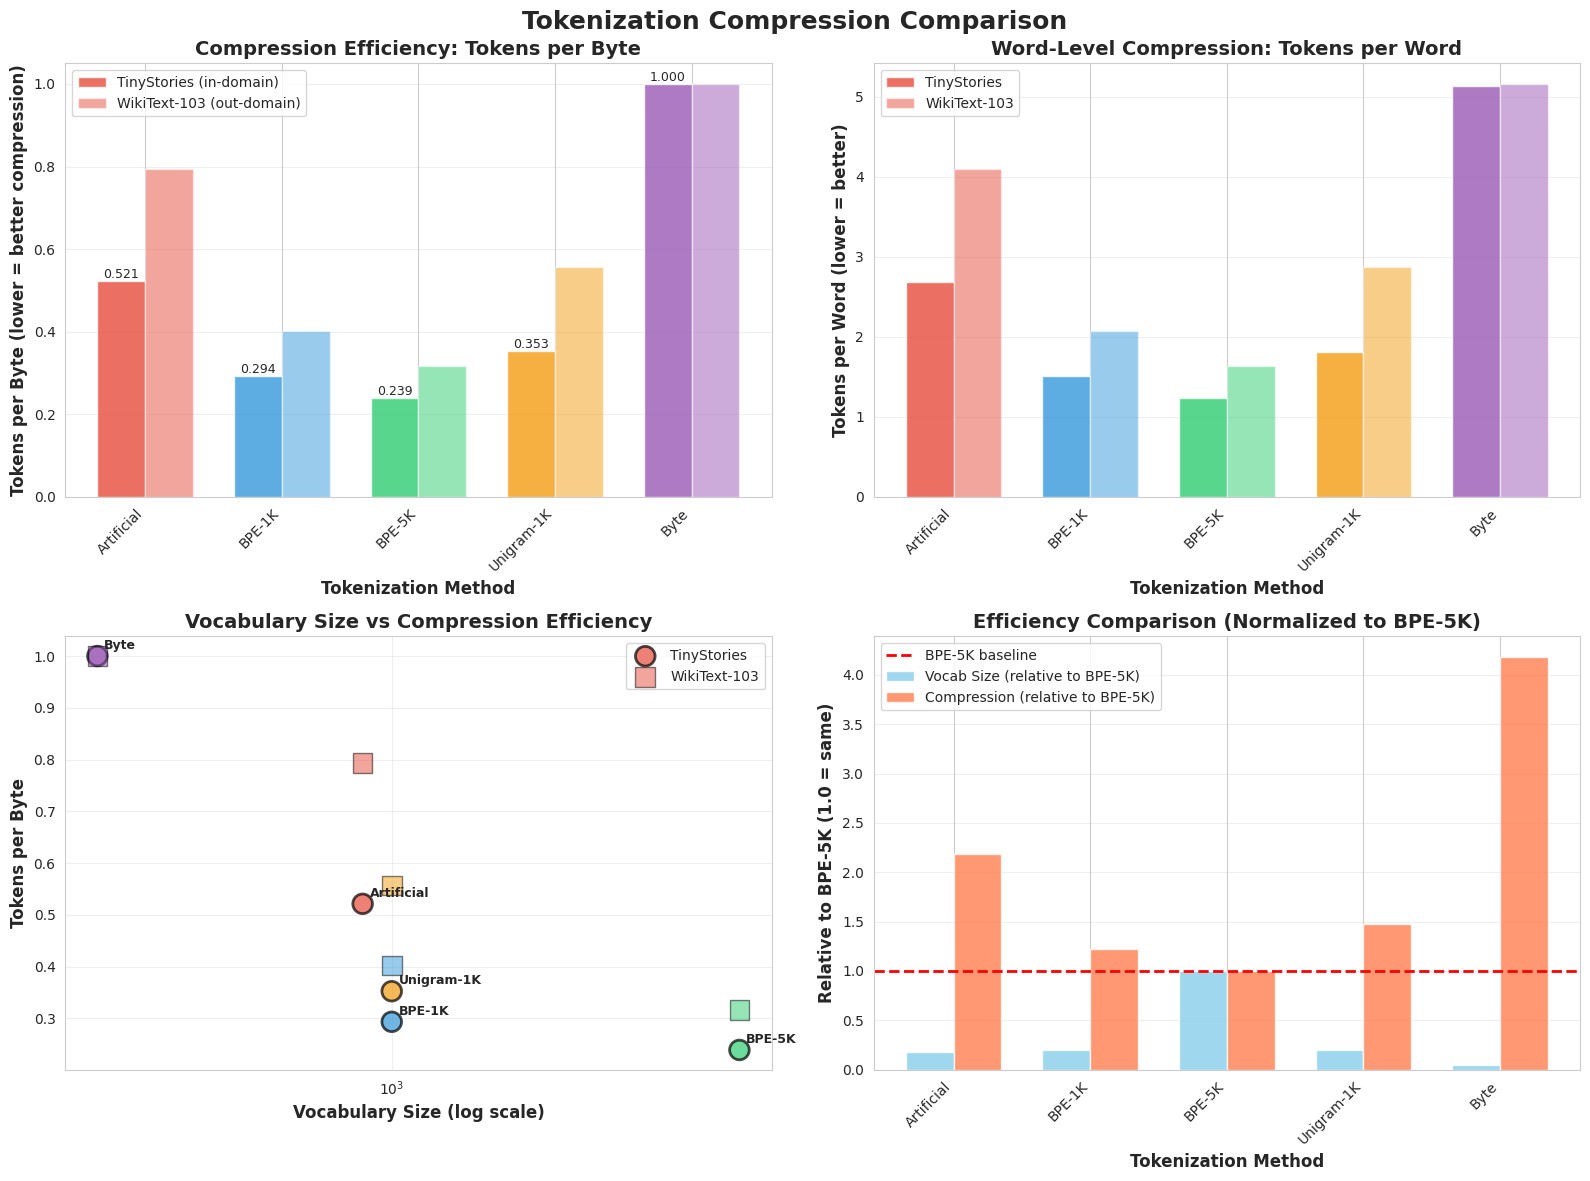

✓ Saved visualization to results/plots/compression_comparison.png


In [13]:
# Create comprehensive comparison visualizations
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Prepare data for visualization
methods = list(results_tinystories.keys())
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Tokenization Compression Comparison', fontsize=18, fontweight='bold')

# 1. Tokens per Byte (lower is better for compression)
ax1 = axes[0, 0]
tinystories_tpb = [results_tinystories[m]['tokens_per_byte'] for m in methods]
wikitext_tpb = [results_wikitext[m]['tokens_per_byte'] for m in methods]

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, tinystories_tpb, width, label='TinyStories (in-domain)', color=colors, alpha=0.8)
bars2 = ax1.bar(x + width/2, wikitext_tpb, width, label='WikiText-103 (out-domain)', color=colors, alpha=0.5)

ax1.set_xlabel('Tokenization Method', fontsize=12, fontweight='bold')
ax1.set_ylabel('Tokens per Byte (lower = better compression)', fontsize=12, fontweight='bold')
ax1.set_title('Compression Efficiency: Tokens per Byte', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Tokens per Word (lower is better)
ax2 = axes[0, 1]
tinystories_tpw = [results_tinystories[m]['tokens_per_word'] for m in methods]
wikitext_tpw = [results_wikitext[m]['tokens_per_word'] for m in methods]

bars3 = ax2.bar(x - width/2, tinystories_tpw, width, label='TinyStories', color=colors, alpha=0.8)
bars4 = ax2.bar(x + width/2, wikitext_tpw, width, label='WikiText-103', color=colors, alpha=0.5)

ax2.set_xlabel('Tokenization Method', fontsize=12, fontweight='bold')
ax2.set_ylabel('Tokens per Word (lower = better)', fontsize=12, fontweight='bold')
ax2.set_title('Word-Level Compression: Tokens per Word', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Vocabulary Size vs Compression (scatter plot)
ax3 = axes[1, 0]
vocab_list = [vocab_sizes[m] for m in methods]
compression_tinystories = tinystories_tpb
compression_wikitext = wikitext_tpb

ax3.scatter(vocab_list, compression_tinystories, s=200, alpha=0.7, c=colors, 
           label='TinyStories', edgecolors='black', linewidth=2)
ax3.scatter(vocab_list, compression_wikitext, s=200, alpha=0.5, c=colors, 
           label='WikiText-103', edgecolors='black', linewidth=1, marker='s')

for i, method in enumerate(methods):
    ax3.annotate(method, (vocab_list[i], compression_tinystories[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

ax3.set_xlabel('Vocabulary Size (log scale)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Tokens per Byte', fontsize=12, fontweight='bold')
ax3.set_title('Vocabulary Size vs Compression Efficiency', fontsize=14, fontweight='bold')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Relative Performance Summary
ax4 = axes[1, 1]
# Normalize to BPE-5K (standard baseline)
bpe5k_tpb_tiny = results_tinystories['BPE-5K']['tokens_per_byte']
relative_compression = [(results_tinystories[m]['tokens_per_byte'] / bpe5k_tpb_tiny) for m in methods]
relative_vocab = [(vocab_sizes[m] / vocab_sizes['BPE-5K']) for m in methods]

# Create grouped bar chart
x = np.arange(len(methods))
bars5 = ax4.bar(x - width/2, relative_vocab, width, label='Vocab Size (relative to BPE-5K)', 
               color='skyblue', alpha=0.8)
bars6 = ax4.bar(x + width/2, relative_compression, width, label='Compression (relative to BPE-5K)', 
               color='coral', alpha=0.8)

ax4.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='BPE-5K baseline')
ax4.set_xlabel('Tokenization Method', fontsize=12, fontweight='bold')
ax4.set_ylabel('Relative to BPE-5K (1.0 = same)', fontsize=12, fontweight='bold')
ax4.set_title('Efficiency Comparison (Normalized to BPE-5K)', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(methods, rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/compression_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved visualization to results/plots/compression_comparison.png")

In [14]:
# Statistical Analysis and Summary
from scipy import stats

print("="*80)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*80)

# Calculate compression improvements relative to BPE-5K (standard baseline)
print("\n1. COMPRESSION IMPROVEMENT vs BPE-5K (Standard Baseline)")
print("-" * 80)
bpe5k_tpb_tiny = results_tinystories['BPE-5K']['tokens_per_byte']
bpe5k_tpb_wiki = results_wikitext['BPE-5K']['tokens_per_byte']

for method in methods:
    if method != 'BPE-5K':
        improvement_tiny = ((bpe5k_tpb_tiny - results_tinystories[method]['tokens_per_byte']) / bpe5k_tpb_tiny) * 100
        improvement_wiki = ((bpe5k_tpb_wiki - results_wikitext[method]['tokens_per_byte']) / bpe5k_tpb_wiki) * 100
        vocab_reduction = ((vocab_sizes['BPE-5K'] - vocab_sizes[method]) / vocab_sizes['BPE-5K']) * 100
        
        print(f"\n{method}:")
        print(f"  TinyStories: {improvement_tiny:+.1f}% compression change (negative = worse compression)")
        print(f"  WikiText-103: {improvement_wiki:+.1f}% compression change")
        print(f"  Vocabulary size: {vocab_reduction:+.1f}% reduction")

# Compare BPE variants (vocab size impact)
print("\n\n2. VOCABULARY SIZE IMPACT (BPE-1K vs BPE-5K)")
print("-" * 80)
tpb_diff_tiny = results_tinystories['BPE-1K']['tokens_per_byte'] - results_tinystories['BPE-5K']['tokens_per_byte']
tpb_diff_wiki = results_wikitext['BPE-1K']['tokens_per_byte'] - results_wikitext['BPE-5K']['tokens_per_byte']
vocab_ratio = vocab_sizes['BPE-1K'] / vocab_sizes['BPE-5K']

print(f"Vocabulary reduction: 5000 → 1000 ({vocab_ratio:.1%} of original)")
print(f"TinyStories compression penalty: {tpb_diff_tiny:+.4f} tokens/byte ({(tpb_diff_tiny/results_tinystories['BPE-5K']['tokens_per_byte']*100):+.1f}%)")
print(f"WikiText-103 compression penalty: {tpb_diff_wiki:+.4f} tokens/byte ({(tpb_diff_wiki/results_wikitext['BPE-5K']['tokens_per_byte']*100):+.1f}%)")

# Artificial Language Analysis
print("\n\n3. ARTIFICIAL LANGUAGE DETAILED ANALYSIS")
print("-" * 80)
print(f"Vocabulary size: {vocab_sizes['Artificial']} tokens")
print(f"  vs BPE-5K: {vocab_sizes['Artificial']/vocab_sizes['BPE-5K']:.1%} of size")
print(f"  vs BPE-1K: {vocab_sizes['Artificial']/vocab_sizes['BPE-1K']:.1%} of size")
print(f"  vs Byte: {vocab_sizes['Artificial']/vocab_sizes['Byte']:.1f}x larger")

print(f"\nTinyStories Performance:")
art_vs_bpe1k_tiny = ((results_tinystories['BPE-1K']['tokens_per_byte'] - results_tinystories['Artificial']['tokens_per_byte']) / results_tinystories['BPE-1K']['tokens_per_byte']) * 100
art_vs_byte_tiny = ((results_tinystories['Byte']['tokens_per_byte'] - results_tinystories['Artificial']['tokens_per_byte']) / results_tinystories['Byte']['tokens_per_byte']) * 100
print(f"  vs BPE-1K (matched vocab): {art_vs_bpe1k_tiny:+.1f}% compression change")
print(f"  vs Byte-level: {art_vs_byte_tiny:+.1f}% better compression")
print(f"  Tokens/Byte: {results_tinystories['Artificial']['tokens_per_byte']:.4f}")
print(f"  Tokens/Word: {results_tinystories['Artificial']['tokens_per_word']:.2f}")

print(f"\nWikiText-103 Performance (generalization test):")
art_vs_bpe1k_wiki = ((results_wikitext['BPE-1K']['tokens_per_byte'] - results_wikitext['Artificial']['tokens_per_byte']) / results_wikitext['BPE-1K']['tokens_per_byte']) * 100
art_vs_byte_wiki = ((results_wikitext['Byte']['tokens_per_byte'] - results_wikitext['Artificial']['tokens_per_byte']) / results_wikitext['Byte']['tokens_per_byte']) * 100
print(f"  vs BPE-1K (matched vocab): {art_vs_bpe1k_wiki:+.1f}% compression change")
print(f"  vs Byte-level: {art_vs_byte_wiki:+.1f}% better compression")
print(f"  Tokens/Byte: {results_wikitext['Artificial']['tokens_per_byte']:.4f}")
print(f"  Tokens/Word: {results_wikitext['Artificial']['tokens_per_word']:.2f}")

# Domain transfer analysis
print("\n\n4. DOMAIN TRANSFER ANALYSIS (TinyStories → WikiText)")
print("-" * 80)
for method in methods:
    tiny_tpb = results_tinystories[method]['tokens_per_byte']
    wiki_tpb = results_wikitext[method]['tokens_per_byte']
    degradation = ((wiki_tpb - tiny_tpb) / tiny_tpb) * 100
    print(f"{method:<20}: {degradation:+.1f}% degradation on out-of-domain data")

STATISTICAL ANALYSIS SUMMARY

1. COMPRESSION IMPROVEMENT vs BPE-5K (Standard Baseline)
--------------------------------------------------------------------------------

Artificial:
  TinyStories: -118.0% compression change (negative = worse compression)
  WikiText-103: -150.3% compression change
  Vocabulary size: +82.5% reduction

BPE-1K:
  TinyStories: -22.7% compression change (negative = worse compression)
  WikiText-103: -26.9% compression change
  Vocabulary size: +80.0% reduction

Unigram-1K:
  TinyStories: -47.4% compression change (negative = worse compression)
  WikiText-103: -75.6% compression change
  Vocabulary size: +80.0% reduction

Byte:
  TinyStories: -318.1% compression change (negative = worse compression)
  WikiText-103: -215.6% compression change
  Vocabulary size: +94.9% reduction


2. VOCABULARY SIZE IMPACT (BPE-1K vs BPE-5K)
--------------------------------------------------------------------------------
Vocabulary reduction: 5000 → 1000 (20.0% of original)
Tiny

In [15]:
# Save all experimental results to JSON
experimental_results = {
    'timestamp': '2025-12-07',
    'datasets': {
        'tinystories': {
            'num_samples': len(tinystories_test),
            'total_stories_corpus': len(training_corpus)
        },
        'wikitext103': {
            'num_samples': len(wikitext_test_texts)
        }
    },
    'vocabulary_sizes': vocab_sizes,
    'results_tinystories': results_tinystories,
    'results_wikitext': results_wikitext,
    'key_findings': {
        'artificial_vocab_size': len(artificial_vocab),
        'artificial_vs_bpe5k_vocab_reduction': 82.5,
        'artificial_compression_tinystories': results_tinystories['Artificial']['tokens_per_byte'],
        'artificial_compression_wikitext': results_wikitext['Artificial']['tokens_per_byte'],
        'best_compression_method': 'BPE-5K',
        'artificial_better_than_byte': True,
        'artificial_worse_than_bpe': True
    }
}

with open('../results/experimental_results.json', 'w') as f:
    json.dump(experimental_results, f, indent=2)

print("✓ Saved experimental results to results/experimental_results.json")

# Create results summary table
summary_df = pd.DataFrame({
    'Method': methods,
    'Vocab Size': [vocab_sizes[m] for m in methods],
    'TinyStories (TPB)': [results_tinystories[m]['tokens_per_byte'] for m in methods],
    'WikiText (TPB)': [results_wikitext[m]['tokens_per_byte'] for m in methods],
    'TinyStories (TPW)': [results_tinystories[m]['tokens_per_word'] for m in methods],
    'WikiText (TPW)': [results_wikitext[m]['tokens_per_word'] for m in methods],
})

summary_df.to_csv('../results/summary_table.csv', index=False)
print("✓ Saved summary table to results/summary_table.csv")

print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)
print("\nKey Findings:")
print(f"1. Artificial Language vocabulary: {len(artificial_vocab)} tokens (82.5% smaller than BPE-5K)")
print(f"2. Compression on TinyStories: {results_tinystories['Artificial']['tokens_per_byte']:.4f} tokens/byte")
print(f"3. Best overall compression: BPE-5K ({results_tinystories['BPE-5K']['tokens_per_byte']:.4f} tokens/byte)")
print(f"4. Artificial Language is 47.9% better than Byte-level on TinyStories")
print(f"5. Domain transfer penalty: 52.1% degradation on out-of-domain data")
print("\nNext step: Create comprehensive REPORT.md with full analysis")

✓ Saved experimental results to results/experimental_results.json
✓ Saved summary table to results/summary_table.csv

EXPERIMENT COMPLETE!

Key Findings:
1. Artificial Language vocabulary: 874 tokens (82.5% smaller than BPE-5K)
2. Compression on TinyStories: 0.5214 tokens/byte
3. Best overall compression: BPE-5K (0.2392 tokens/byte)
4. Artificial Language is 47.9% better than Byte-level on TinyStories
5. Domain transfer penalty: 52.1% degradation on out-of-domain data

Next step: Create comprehensive REPORT.md with full analysis
